### Programa de bicicletas compartidas (Bike Rent Predictions)

Descripción del prolema: Poniéndonos en la situación de que somos parte del equipo de la empresa Rent-Cycle en Wachington DC, y nuestro Team Leader nos da la tarea de implementar un modelo que nos permita predecir la cantidad de bicicletas que se alquilan según la información contenida en el dataset puesto a disposición.

### Procedimiento

1. Librerías
2. Cargar datasets
3. Análisis Exploratorio de datos
(3.1. Búsqueda de valores faltantes,
3.2. Correlación de variables,
3.3. Distribuiciones)
4. Feature Engineering
5. Pre-procesamiento
6. Modelos de entrenamiento
(6.1. Random Forest,
6.2. XGBoost,
6.3. Red Neuronal)

### 1. Importamos todas las librerías que vamos a utilizar

In [1]:
import pandas as pd
import datetime as dt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import numpy as np
import math
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

### Creación Dataset

creamos el data set con el csv de entrenamiento

In [2]:
df_train = pd.read_excel('bike_train.xlsx')
df_train.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df_test = pd.read_excel('bike_test.xlsx')
df_test.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,2012-05-20,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,2012-05-20,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,2012-05-20,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


### 3. Análisis Exploratorio

In [4]:
df_train.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
df_test.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

*Correlación de variables*

Eliminamos las variables instant y dteday

In [6]:
df_train.drop(labels=['instant','dteday'], axis=1, inplace=True)

In [7]:
import itertools
from sklearn.metrics import confusion_matrix

def make_correlation(df, figsize = (20,10), text_size = 8):
  
  # Creamos matriz de confusion
    cm = df.corr().values
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize = figsize)
    cax = ax.matshow(cm, cmap = plt.cm.Blues)

    # Establecemos labels para las classes
    labels = df.columns

    # Label the axes
    ax.set(title = "Correlation Matrix",
            xticks = np.arange(n_classes),
            yticks = np.arange(n_classes),
            xticklabels = labels, # axes se etiquetarán con nombres de clase (si existen) o enteros
            yticklabels = labels)
  
    # Establecemos x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Ajustas tamaño label
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)
    fig.autofmt_xdate(rotation=70)


    # Establecemos threshold para diferentes colores
    threshold = (cm.max() + cm.min())/2.

    # Dibujamos el texto en cada celda
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{round(cm[i,j], 2)}%",
             horizontalalignment = "center",
             color = "white" if cm[i, j] > threshold else "black",
             size = text_size)

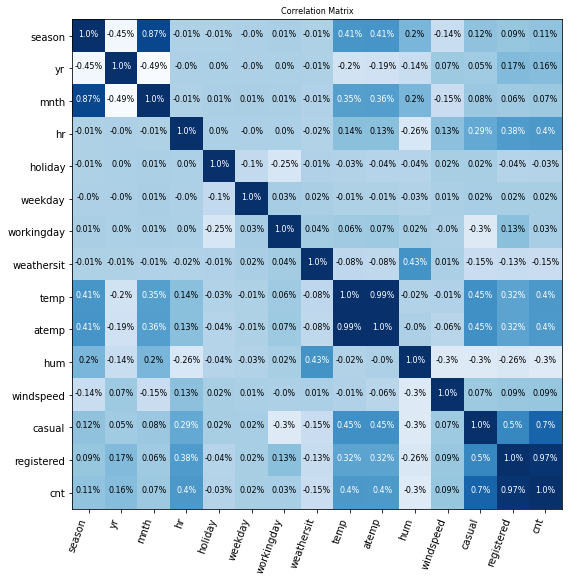

In [8]:
make_correlation(df_train)

Se eliminarán "casual" y "registered" ya que estas son las que componen el 100% de la variable a predecir "cnt"

Se eliminarán variables independientes que tengan altos niveles de correlación: 1) season y mnth (0.87) 2) temp y atemp (0.99)

Se eliminarán variables con relaciones casi nulas, eliminaremos las que esten en el rango de -0.1 y 0.1

In [9]:
df_train.corr()
#mnth(0.07) holiday(-0.03) workingday(0.03) weekday(0.02) windspeed(0.09)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
season,1.000000,-0.446665,0.865268,-0.007610,-0.008928,-0.003688,0.012630,-0.009029,0.410790,0.413196,0.198937,-0.142924,0.119043,0.093595,0.111369
yr,-0.446665,1.000000,-0.488103,-0.003948,0.001039,-0.002714,0.001068,-0.006309,-0.198929,-0.190360,-0.141319,0.067356,0.053371,0.171910,0.156960
mnth,0.865268,-0.488103,1.000000,-0.007060,0.009372,0.014500,0.006441,-0.012239,0.353330,0.358541,0.201669,-0.147042,0.078563,0.061686,0.073431
hr,-0.007610,-0.003948,-0.007060,1.000000,0.000414,-0.004037,0.003454,-0.024003,0.139251,0.134633,-0.257202,0.130441,0.285182,0.381933,0.396698
holiday,-0.008928,0.001039,0.009372,0.000414,1.000000,-0.102503,-0.248601,-0.014707,-0.028519,-0.038005,-0.036672,0.022681,0.022140,-0.044534,-0.030304
weekday,-0.003688,-0.002714,0.014500,-0.004037,-0.102503,1.000000,0.031057,0.017259,-0.010002,-0.009841,-0.025932,0.008447,0.023687,0.019179,0.022618
workingday,0.012630,0.001068,0.006441,0.003454,-0.248601,0.031057,1.000000,0.042202,0.062273,0.066305,0.022805,-0.002493,-0.298241,0.134789,0.025132
weathersit,-0.009029,-0.006309,-0.012239,-0.024003,-0.014707,0.017259,0.042202,1.000000,-0.080149,-0.081386,0.430378,0.009195,-0.147903,-0.130223,-0.149848
temp,0.410790,-0.198929,0.353330,0.139251,-0.028519,-0.010002,0.062273,-0.080149,1.000000,0.991785,-0.019289,-0.013984,0.450777,0.322875,0.395743
atemp,0.413196,-0.190360,0.358541,0.134633,-0.038005,-0.009841,0.066305,-0.081386,0.991785,1.000000,-0.003669,-0.057619,0.447899,0.323264,0.395234


In [10]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11999.0,2.210684,1.088798,1.00,1.0000,2.0000,3.0000,4.0000
yr,11999.0,0.279523,0.448784,0.00,0.0000,0.0000,1.0000,1.0000
mnth,11999.0,5.530294,3.433005,1.00,3.0000,5.0000,8.0000,12.0000
hr,11999.0,11.556630,6.911891,0.00,6.0000,12.0000,18.0000,23.0000
holiday,11999.0,0.027752,0.164269,0.00,0.0000,0.0000,0.0000,1.0000
weekday,11999.0,3.009334,2.005264,0.00,1.0000,3.0000,5.0000,6.0000
workingday,11999.0,0.684057,0.464910,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,11999.0,1.435036,0.650894,1.00,1.0000,1.0000,2.0000,4.0000
temp,11999.0,0.465704,0.188576,0.02,0.3200,0.4600,0.6200,0.9600
atemp,11999.0,0.448888,0.169633,0.00,0.3030,0.4545,0.5909,1.0000


### Distribuiciones

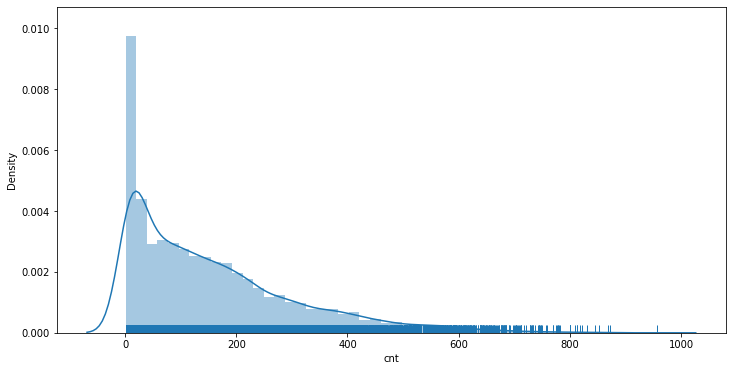

In [11]:
# Se observa un sesgo positivo, por lo que existen outliers, por lo que analizaremos qué método utilizar para no ensuciar las predicciones

target = df_train['cnt']
plt.figure(figsize=(12,6))
sns.distplot(target, rug = True)
plt.show(); 

Transformación log-scale

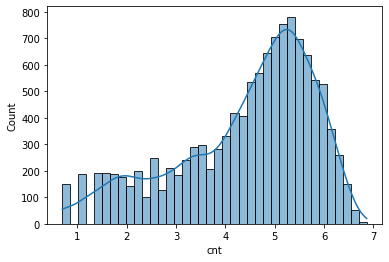

In [12]:
#Debido al sesgo a la derecha, se aplicara una transformación logarítica para llegar a un nivel más proximmo a la normalidad
target_log = np.log1p(target)
sns.histplot(target_log, kde=True)
plt.show()

Análisis de cuartiles: Ley de Tukey <br>
* q > Q1 - 1.5*IRQ  <br>
* q < Q3 - 1.5*IRQ

<AxesSubplot:ylabel='cnt'>

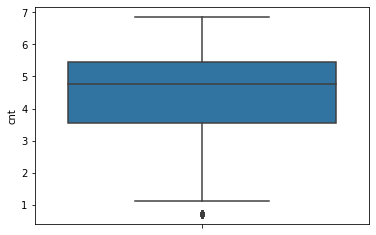

In [13]:
sns.boxplot(y = target_log)

In [14]:
cuartiles = pd.qcut(target_log, q = [0,0.25,0.5,0.75,1], retbins = True)[1]

Q1 = cuartiles[1]
Q2 = cuartiles[2]
Q3 = cuartiles[3]

IQR = Q3-Q1

In [15]:
outl_q = target_log.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 -1.5*IQR) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

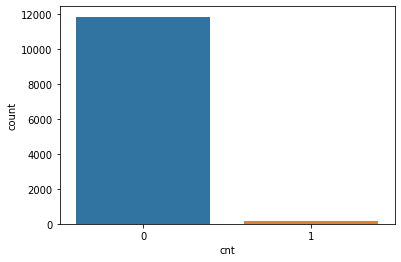

In [16]:
#Cantidad de registros (0: no outliers, 1: outliers)
sns.countplot(outl_q)

In [17]:
outl_q.value_counts()

0    11850
1      149
Name: cnt, dtype: int64

Análisis de las 3 sigmas <br>
* mínimo = Promedio -3*Desviación Estándar <br>
* máximo = Promedio -3*Desviación Estándar

In [18]:
std = np.std(target_log)
mean = np.mean(target_log)

In [19]:
outl_s = target_log.apply(lambda e: 1 if (e > mean + 3*std)|(e < mean - 3*std) else 0)

<AxesSubplot:xlabel='cnt', ylabel='count'>

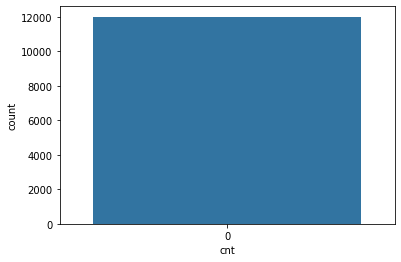

In [20]:
sns.countplot(outl_s)

In [21]:
outl_s.value_counts()

0    11999
Name: cnt, dtype: int64

In [22]:
df_train['outlier'] = outl_q
df_train['outlier'].value_counts()

0    11850
1      149
Name: outlier, dtype: int64

### Variables Predictoras

*visualización de features categóricos* <br>
Datos categóricos: season, workingday, weathersit, holiday, yr, mnth, weekday

                         Visualización de features categóricos (train):                         


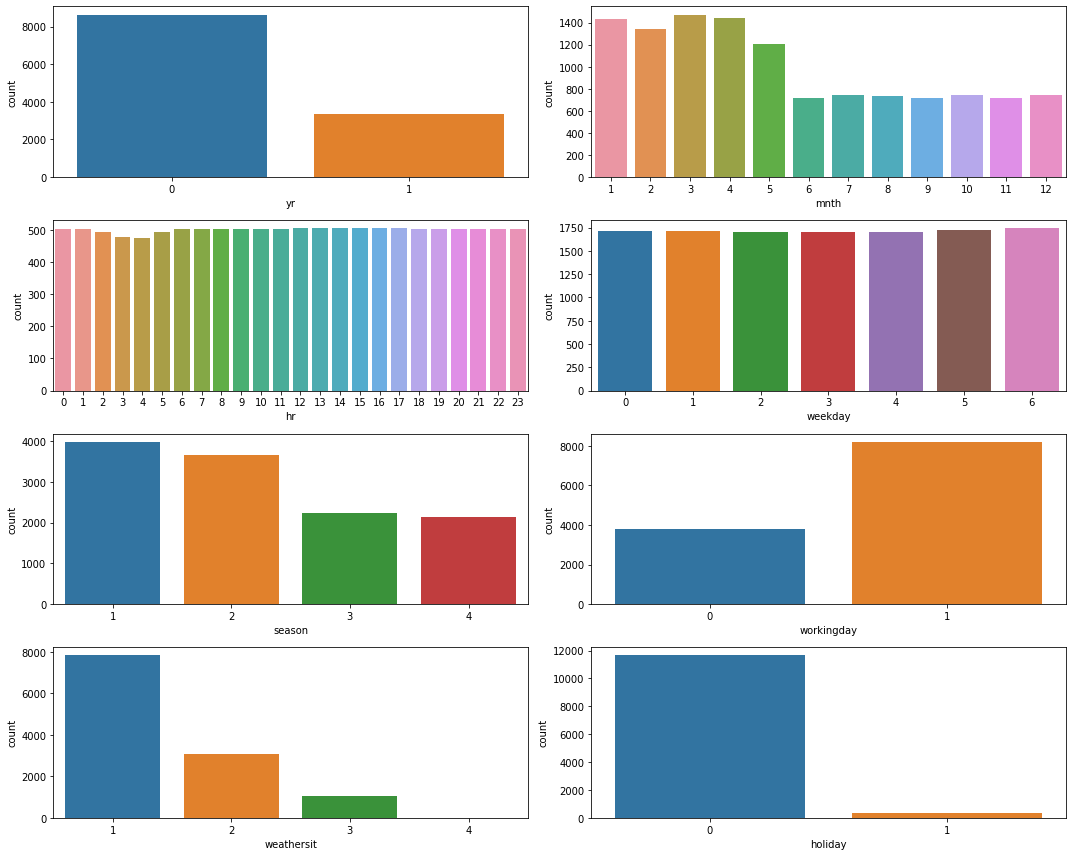

In [23]:
print('\033[1mVisualización de features categóricos (train):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df_train[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(df_train[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(df_train[cf[i]])

plt.tight_layout()
plt.show()

Podemos observar que en el feature 'weathersit' el valor 4 es casi nulo, por lo que se eliminará para procesar apenas 3 valores en el entrenamiento

In [24]:
df_train['weathersit'].value_counts()

1    7843
2    3095
3    1058
4       3
Name: weathersit, dtype: int64

In [25]:
#nos quedamos con los casos que el weathersit no sea 4
df_train = df_train.loc[df_train['weathersit']!=4]

                         Visualización de features categóricos (test):                          


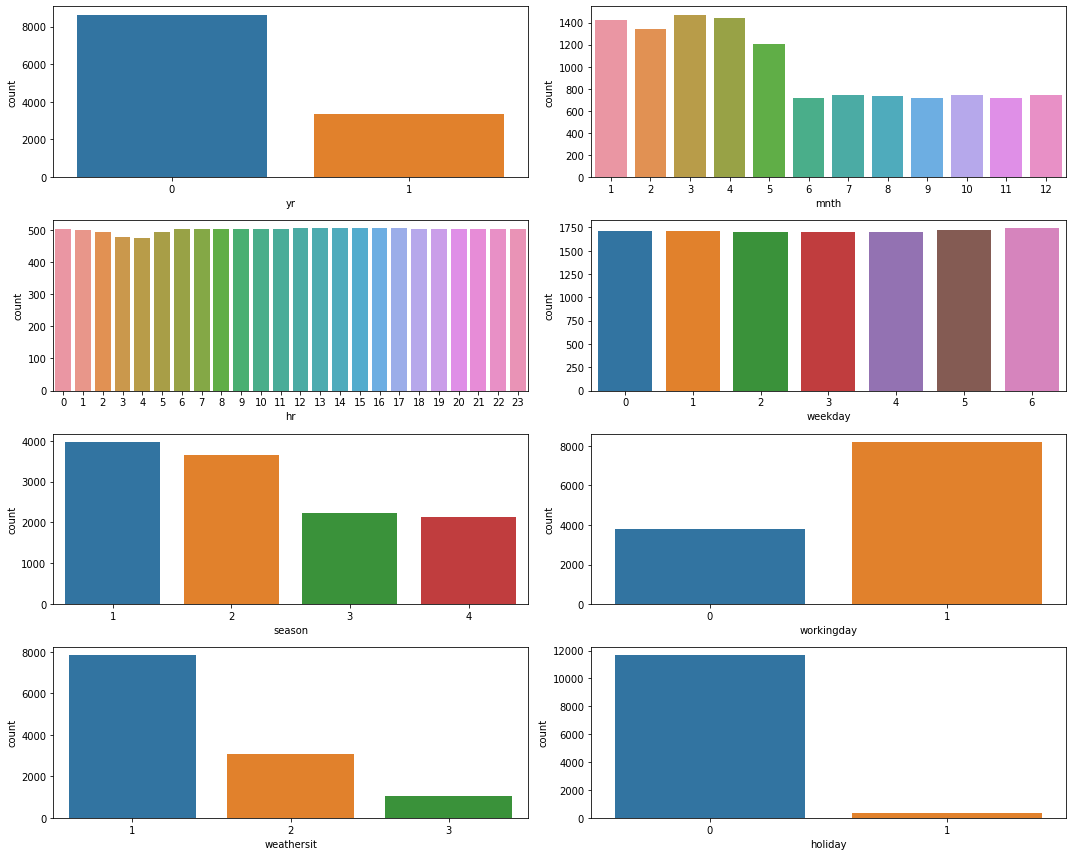

In [26]:
print('\033[1mVisualización de features categóricos (test):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df_train[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie df[cf[i]]
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(df_train[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(df_train[cf[i]])

plt.tight_layout()
plt.show()

### Visualización de features numéricos

                                          Distribución de features numéricos (train)                                          


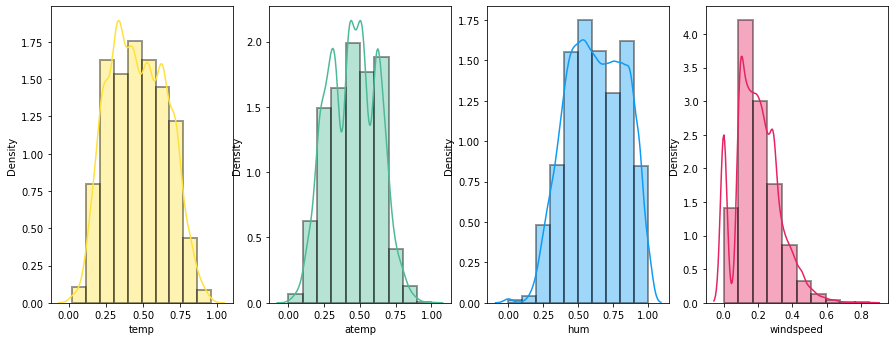

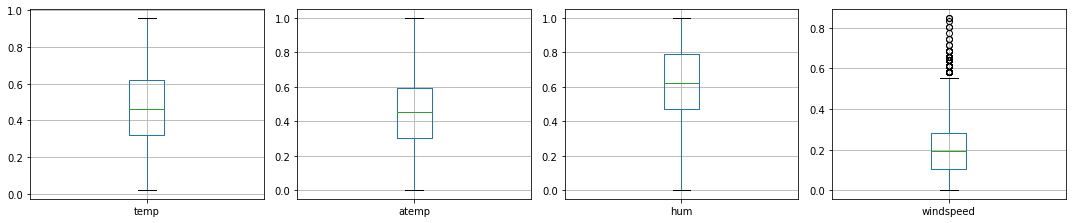

In [27]:
print('\033[1mDistribución de features numéricos (train)'.center(130))

n = 4
nf = ['temp', 'atemp', 'hum', 'windspeed']
clr = ['r', 'g', 'b', 'g', 'b', 'r']

plt.figure(figsize = [15, 6*math.ceil(len(cf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    sns.distplot(df_train[nf[i]], hist_kws = dict(edgecolor = 'black', linewidth = 2), 
               bins = 10, color = list(np.random.randint([255,255,255])/255))

plt.figure(figsize = [15, 6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    df_train.boxplot(nf[i])

plt.tight_layout()
plt.show()

*Observamos outliers en WINDSPEED*

In [28]:
cuart = pd.qcut(df_train.windspeed, q = [0,.25,.50,.75,1], retbins = True)[1]
Q1 = cuart[1]
Q2 = cuart[2]
Q3 = cuart[3]
IQR = Q3 - Q1
wind_q = df_train.windspeed.apply(lambda e: 1 if (e > Q3 + 1.5*IQR)|(e < Q1 - 1.5*IQR) else 0)

In [29]:
len(wind_q[wind_q == 1]) # 86 registros como outliers, procederemos a eliminar esos registros

86

In [30]:
df_train['outlier_wind'] = wind_q
df_train = df_train[df_train['outlier_wind']==0]
df_train = df_train[df_train['outlier']==0]

In [31]:
df_train.shape

(11763, 17)

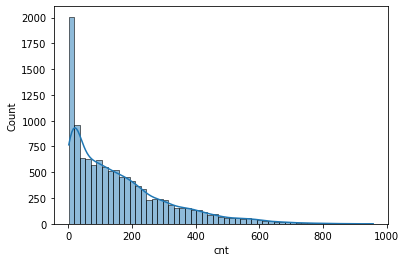

In [32]:
sns.histplot(df_train.cnt, kde=True)
plt.show()

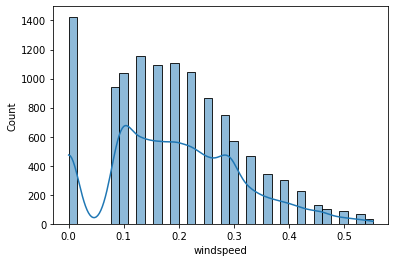

In [33]:
sns.histplot(df_train.windspeed, kde=True)
plt.show()

Midiendo los features temp, atemp, hum, windspeed, mediante estadísticos de asimetría y curtosis, para detectar su distruibición normal. <br>
Un valor de curtosis y/o asimetría entre -1 y 1, se considera una ligera desviación de la normalidad.

In [34]:
print('Kursotis:', stats.kurtosis(df_train['atemp']))
print('Skewness:', stats.skew(df_train['atemp']))

Kursotis: -0.7600648088483037
Skewness: 0.025539643774868656


In [35]:
print('Kursotis:', stats.kurtosis(df_train['temp']))
print('Skewness:', stats.skew(df_train['temp']))

Kursotis: -0.849353142865402
Skewness: 0.11282410547876524


In [36]:
print('Kursotis:', stats.kurtosis(df_train['hum']))
print('Skewness:', stats.skew(df_train['hum']))

Kursotis: -0.8484358089660531
Skewness: -0.09269705091338305


In [37]:
print('Kursotis:', stats.kurtosis(df_train['windspeed']))
print('Skewness:', stats.skew(df_train['windspeed']))

Kursotis: -0.18691308677846852
Skewness: 0.3481253696771268


### 4. Feature Engineering

*selección de features con regresión linear*

In [38]:
train_prep_1 = df_train.drop(['casual','registered', 'outlier', 'outlier_wind'], axis = 1).copy()

In [39]:
train_prep_1.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [40]:
X_reg = train_prep_1.drop(['cnt'], axis=1)
y_reg = train_prep_1['cnt']

In [41]:
import statsmodels.api as sm
X_constant = sm.add_constant(X_reg)
lin_reg = sm.OLS(y_reg,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     577.5
Date:                Thu, 20 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:45:59   Log-Likelihood:                -73026.
No. Observations:               11763   AIC:                         1.461e+05
Df Residuals:                   11750   BIC:                         1.462e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.3992      7.237     -3.371      0.001     -38.585     -10.213
season        12.8989      2.091      6.170      0.000       8.801      16.997
yr            87.3591      2.870     30.437      0.000      81.733      92.985
mnth           1.6866      0.665      2.537      0.011       0.383       2.990
hr             6.4686      0.169     38.287      0.000       6.137       6.800
holiday      -22.2531      7.006     -3.176      0.001     -35.985      -8.521
weekday        1.6252      0.557      2.918      0.004       0.533       2.717
workingday    -0.5517      2.470     -0.223      0.823      -5.393       4.289
weathersit    -6.2103      1.946     -3.191      0.001     -10.025      -2.395
temp          37.3701     49.692      0.752      0.452     -60.035     134.776
atemp        271.1497     55.340      4.900      0.000     162.674     379.626
hum         -149.9379      6.873    -21.816      0.000    -163.410    -136.466
windspeed     32.6283     10.325      3.160      0.002      12.389      52.867
==============================================================================
Omnibus:                     2197.359   Durbin-Watson:                   0.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4115.029
Skew:                           1.161   Prob(JB):                         0.00
Kurtosis:                       4.734   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Variables no significativas (>0.05) encontradas en el modelo son: <br>
* workingday
* temp 

### Selección de features con recursive feature elimination

In [42]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
model = XGBRegressor()

selector = RFECV(model, step=3, min_features_to_select = 3, cv = 4)
selector.fit(X_reg,y_reg)

RFECV(cv=4,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             gamma=None, gpu_id=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=None, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             predictor=None, random_state=None, reg_alpha=None,
                             reg_lambda=None, ...),
      min_features_to_select=3, step=3)

In [43]:
print(X_reg.columns)
print(selector.ranking_)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')
[1 1 1 1 1 1 1 1 1 1 1 1]


In [44]:
selector.grid_scores_.mean()  # Promedio de R^2 para CV en 4

0.6099273338613581

Variables más importantes: season, yr, hr, workingday, weathersit, temp <br>
<br>
Variables menos importantes: mnth, hum, windspeed

### 5. Preprocesamiento de Datos

In [45]:
train_df_prep_1 = df_train.drop(['outlier','outlier_wind','casual','registered'], axis=1)
train_df_prep_1 = train_df_prep_1[train_df_prep_1['weathersit']<=3]
train_df_prep_1

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
6,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994,2,1,5,23,0,6,0,1,0.60,0.6212,0.56,0.1642,239
11995,2,1,5,0,0,0,0,1,0.58,0.5455,0.53,0.1045,170
11996,2,1,5,1,0,0,0,1,0.56,0.5303,0.52,0.0000,130
11997,2,1,5,2,0,0,0,1,0.56,0.5303,0.52,0.0000,98


### 5.1. Usando el 1er método de selección + correlación lineal

Eliminamos temp, workingday y mnth

In [46]:
train_prep_fs_1 = train_df_prep_1.drop(['temp','workingday','mnth'], axis=1)
train_prep_fs_1.columns

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'weathersit', 'atemp',
       'hum', 'windspeed', 'cnt'],
      dtype='object')

*Variables dummies* 

Variables categoricas nominales: season, weathersit, holiday, weekday, yr, hr <br>
No es necesario holiday y yr porque poseen valores de 0 y 1

In [47]:
train_prep_fs_1_2 = train_prep_fs_1.copy()
#train_prep_fs_1_2 = pd.get_dummies(train_prep_fs_1, columns=['season','hr','weathersit','weekday'])
train_prep_fs_1_2.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,1,0.2879,0.75,0.0,13
6,1,0,6,0,6,1,0.2727,0.80,0.0,2


In [48]:
train_df_prep_1['cnt'] = np.log(train_df_prep_1['cnt'])

*Escalado de las variables* <br>
Manejaremos un escalado StandarScaler para la variable objetivo

In [49]:
train_prep_fs_1_3 = train_prep_fs_1_2.copy()

In [50]:
st_output = MinMaxScaler()
train_prep_fs_1_3.loc[:,['cnt']] = st_output.fit_transform(train_prep_fs_1_3.loc[:,['cnt']])

In [51]:
train_prep_fs_1_3.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11763.0,2.225028,1.088084,1.0,1.000000,2.000000,3.000000,4.0000
yr,11763.0,0.278670,0.448364,0.0,0.000000,0.000000,1.000000,1.0000
hr,11763.0,11.634107,6.903735,0.0,6.000000,12.000000,18.000000,23.0000
holiday,11763.0,0.027969,0.164891,0.0,0.000000,0.000000,0.000000,1.0000
weekday,11763.0,3.009181,2.005455,0.0,1.000000,3.000000,5.000000,6.0000
weathersit,11763.0,1.431778,0.646495,1.0,1.000000,1.000000,2.000000,3.0000
atemp,11763.0,0.451582,0.168838,0.0,0.318200,0.454500,0.590900,1.0000
hum,11763.0,0.626227,0.200008,0.0,0.470000,0.620000,0.790000,1.0000
windspeed,11763.0,0.193259,0.120032,0.0,0.104500,0.194000,0.283600,0.5522
cnt,11763.0,0.166147,0.158703,0.0,0.035602,0.124607,0.242932,1.0000


*Otra manera* <br>
<br>
*División del conjuntos de datos en train y validation*

In [52]:
train_prep_fs_1.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,1,0.2879,0.75,0.0,13
6,1,0,6,0,6,1,0.2727,0.80,0.0,2


In [53]:
train_prep_fs_1.shape

(11763, 10)

In [54]:
X_1 = train_prep_fs_1.drop(['cnt'], axis=1)
y_1 = train_prep_fs_1['cnt']

In [55]:
train_X_1, val_X_1, train_y_1, val_y_1 = train_test_split(X_1, y_1, test_size=0.15, random_state = 2208)

### 5.2. Usando el 2do método de selección + Correlación lineal

Eliminamos winspeed, season, hum, temp

In [56]:
train_prep_fs_2 = train_df_prep_1.drop(['windspeed','temp','season','hum'], axis=1)

In [57]:
train_prep_fs_2.columns

Index(['yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
       'atemp', 'cnt'],
      dtype='object')

In [58]:
train_prep_fs_1_2 = train_prep_fs_1.copy()
# train_prep_fs_1_2 = pd.get_dummies(train_prep_fs_1, columns=['season', 'hr', 'weathersit', 'weekday'])
train_prep_fs_1_2.head()

,season,yr,hr,holiday,weekday,weathersit,atemp,hum,windspeed,cnt
0,1,0,0,0,6,1,0.2879,0.81,0.0,16
1,1,0,1,0,6,1,0.2727,0.80,0.0,40
2,1,0,2,0,6,1,0.2727,0.80,0.0,32
3,1,0,3,0,6,1,0.2879,0.75,0.0,13
6,1,0,6,0,6,1,0.2727,0.80,0.0,2


In [59]:
train_df_prep_1['cnt'] = np.log1p(train_df_prep_1['cnt'])

In [60]:
st_output = MinMaxScaler()
train_prep_fs_1_3.loc[:,['cnt']] = st_output.fit_transform(train_prep_fs_1_3.loc[:,['cnt']])

In [61]:
train_prep_fs_1_3.describe().T

,count,mean,std,min,25%,50%,75%,max
season,11763.0,2.225028,1.088084,1.0,1.000000,2.000000,3.000000,4.0000
yr,11763.0,0.278670,0.448364,0.0,0.000000,0.000000,1.000000,1.0000
hr,11763.0,11.634107,6.903735,0.0,6.000000,12.000000,18.000000,23.0000
holiday,11763.0,0.027969,0.164891,0.0,0.000000,0.000000,0.000000,1.0000
weekday,11763.0,3.009181,2.005455,0.0,1.000000,3.000000,5.000000,6.0000
weathersit,11763.0,1.431778,0.646495,1.0,1.000000,1.000000,2.000000,3.0000
atemp,11763.0,0.451582,0.168838,0.0,0.318200,0.454500,0.590900,1.0000
hum,11763.0,0.626227,0.200008,0.0,0.470000,0.620000,0.790000,1.0000
windspeed,11763.0,0.193259,0.120032,0.0,0.104500,0.194000,0.283600,0.5522
cnt,11763.0,0.166147,0.158703,0.0,0.035602,0.124607,0.242932,1.0000


*División del conjunto de datos en train y validation*

In [62]:
train_prep_fs_2.head()

,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,cnt
0,0,1,0,0,6,0,1,0.2879,2.772589
1,0,1,1,0,6,0,1,0.2727,3.688879
2,0,1,2,0,6,0,1,0.2727,3.465736
3,0,1,3,0,6,0,1,0.2879,2.564949
6,0,1,6,0,6,0,1,0.2727,0.693147


In [63]:
train_prep_fs_2.shape

(11763, 9)

In [64]:
X_2 = train_prep_fs_2.drop(['cnt'], axis = 1)
y_2 = train_prep_fs_2['cnt']

In [65]:
train_X_2, val_X_2, train_y_2, val_y_2 = train_test_split(X_2, y_2, test_size=0.15, random_state = 2208)

# 6. Modelos de entrenamiento

## Random Forest

##### 1ero

In [66]:
my_param_grid = {'n_estimators':[100, 250, 500], 'max_features':['sqrt', 'log2'], 'max_depth':[10, 20]}

In [67]:
rf_1 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = my_param_grid, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error')
rf_1.fit(train_X_1, train_y_1)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   1.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   1.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   1.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   1.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   1.0s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=500; total time=   2.0s
[CV] END ..max_depth=10, max_features=sqrt, n_es

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [68]:
rf_1.best_estimator_

RandomForestRegressor(max_depth=20, max_features='log2', n_estimators=500)

In [69]:
# Este es
rf_1.best_score_*(-1)

53.58834686045138

In [70]:
# Este es
from tkinter import Grid


y_hat_1 = rf_1.predict(val_X_1)
y_hat_1

array([  9.54074988, 119.86916667,  15.58316667, ..., 325.09569718,
        19.78920768, 333.08668016])

In [71]:
rf_1 = RandomForestRegressor(max_depth= 20, max_features = 'sqrt', n_estimators= 500)
rf_1.fit(train_X_1, train_y_1)

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=500)

In [72]:
rf_pred_1 = rf_1.predict(val_X_1)
rf_pred_1

array([  9.09953599, 118.02162222,  14.02142857, ..., 323.63611118,
        20.02258725, 335.82511457])

In [73]:
predicns = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])
predicns['predict_val'] = rf_pred_1.reshape(-1,1)
predicns

,true_val,predict_val
0,3,9.099536
1,119,118.021622
2,10,14.021429
3,104,113.147867
4,10,16.314050
...,...,...
1760,102,161.555753
1761,91,107.609000
1762,285,323.636111
1763,5,20.022587


In [74]:
rmse = round(np.sqrt(mean_squared_error(predicns['true_val'], predicns['predict_val'])),4)
rmse

49.0308

In [75]:
# Este es
predictions = pd.DataFrame(val_y_1.values.reshape(-1,1), columns=['true_val'])
predictions['predict_val'] = y_hat_1.reshape(-1,1)
predictions

,true_val,predict_val
0,3,9.540750
1,119,119.869167
2,10,15.583167
3,104,108.394679
4,10,17.460001
...,...,...
1760,102,158.316029
1761,91,106.574000
1762,285,325.095697
1763,5,19.789208


In [76]:
rmse = round(np.sqrt(mean_squared_error(predictions['true_val'], predictions['predict_val'])),4)
rmse

49.2176

## XGBoost

In [77]:
from sklearn import metrics

In [78]:
def rmse(y_true, y_prediction):
    return np.sqrt(mean_squared_error(y_true, y_prediction))
rmse_scorer = metrics.make_scorer(rmse, greater_is_better = False)

In [79]:

def rmse(y_true, y_prediction):
    return np.sqrt(mean_squared_error(y_true, y_prediction))
rmse_scorer = metrics.make_scorer(rmse, greater_is_better = False)
# model
model = xgb.XGBRegressor()
parameters = {'n_estimators': [100, 150], 'max_depth': [10,20], 'learning_rate': [0.08, 0.1, 0.15]}
gridsearch_model = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 2)
gridsearch_model.fit(train_X_1, train_y_1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   0.7s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   0.5s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=100; total time=   0.4s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   0.6s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   0.7s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   0.6s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   0.6s
[CV] END .learning_rate=0.08, max_depth=10, n_estimators=150; total time=   0.6s
[CV] END .learning_rate=0.08, max_depth=20, n_estimators=100; total time=   2.3s
[CV] END .learning_rate=0.08, max_depth=20, n_es

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.08, 0.1, 0.15],
                         'max_depth': [10, 20], 'n_estimators': [100, 150]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [80]:
print('Mejor modelo: ', gridsearch_model.best_params_)

Mejor modelo:  {'learning_rate': 0.08, 'max_depth': 10, 'n_estimators': 150}


In [81]:
gridsearch_model.best_score_*(-1)

38.92469449644713

In [82]:
xg_1 = xgb.XGBRegressor(n_estimators = 150, max_depth = 20, learning_rate =0.15)
xg_1.fit(train_X_1, train_y_1)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [83]:
xg_1.predict(val_X_1).reshape(-1,1)

array([[  4.7671   ],
       [112.57505  ],
       [  7.6672015],
       ...,
       [336.02405  ],
       [  7.420625 ],
       [339.19107  ]], dtype=float32)

# Red Neuronal

In [84]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomUniform
import os
from tensorflow.keras.models import Model, load_model

In [85]:
# Creamos una función para implementar una devolución de llamada de ModelCheckpoint con un nombre de archivo específico
def create_model_checkpoint(model_name, save_path="model_experiments_2"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, 
                                            save_best_only=True) 

In [86]:
def model_MLANN(train, train_label, test, test_label, name):
    
    model = tf.keras.Sequential([
        layers.Dense(12, activation = 'tanh', input_shape = (9,)),
        layers.Dense(1),
    ], name = name)
    
    model.compile(loss = 'mse',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.08),
                  metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(train, train_label, epochs = 150,callbacks = [create_model_checkpoint(model_name=model.name)], validation_data =(test,test_label), verbose = 2)
    
    return model, history

train_X_1, val_X_1, train_y_1, val_y_1 

In [87]:
rn_model, history = model_MLANN(train_X_1, train_y_1, val_X_1, val_y_1, 'rn_model')

Epoch 1/150
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
313/313 - 1s - loss: 25124.8809 - root_mean_squared_error: 158.5083 - val_loss: 18147.0410 - val_root_mean_squared_error: 134.7110 - 1s/epoch - 4ms/step
Epoch 2/150
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
313/313 - 1s - loss: 15988.9336 - root_mean_squared_error: 126.4474 - val_loss: 15223.1846 - val_root_mean_squared_error: 123.3823 - 516ms/epoch - 2ms/step
Epoch 3/150
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
313/313 - 1s - loss: 14164.3320 - root_mean_squared_error: 119.0140 - val_loss: 13525.4414 - val_root_mean_squared_error: 116.2989 - 517ms/epoch - 2ms/step
Epoch 4/150
INFO:tensorflow:Assets written to: model_experiments_2\rn_model\assets
313/313 - 1s - loss: 12914.2705 - root_mean_squared_error: 113.6410 - val_loss: 12347.4609 - val_root_mean_squared_error: 111.1191 - 538ms/epoch - 2ms/step
Epoch 5/150
INFO:tensorflow:Assets written to: 

In [88]:
rn_model.evaluate(val_X_1, val_y_1)

56/56 [==============================] - 0s 636us/step - loss: 9033.3691 - root_mean_squared_error: 95.0440


[9033.369140625, 95.04403686523438]

In [89]:
rn_best_model = tf.keras.models.load_model(f"model_experiments_2/rn_model")

In [90]:
rn_best_model.evaluate(val_X_1, val_y_1)

56/56 [==============================] - 0s 727us/step - loss: 8818.4248 - root_mean_squared_error: 93.9065


[8818.4248046875, 93.9064712524414]

In [91]:
history_rn = pd.DataFrame(history.history)
history_rn

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,25124.880859,158.508301,18147.041016,134.710953
1,15988.933594,126.447357,15223.184570,123.382271
2,14164.332031,119.014000,13525.441406,116.298935
3,12914.270508,113.640968,12347.460938,111.119133
4,12283.652344,110.831642,11846.390625,108.841125
...,...,...,...,...
145,9410.812500,97.009346,10406.928711,102.014359
146,9090.031250,95.341652,9019.312500,94.970062
147,9301.880859,96.446259,9032.536133,95.039658
148,8947.213867,94.589714,9430.826172,97.112442


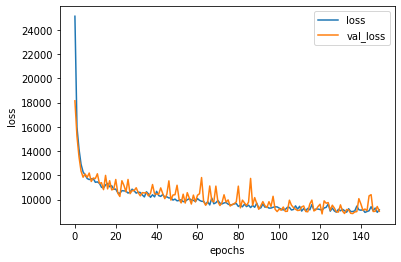

In [92]:
plt.plot(history_rn.index, history_rn['loss'])
plt.plot(history_rn.index, history_rn['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show();